# Spam SMS Detection

**(This is a solution to one of the tasks I took during my internship @CODSOFT)**

_In this notebook, I attempt to create a AI model that can classify SMS messages as spam or legitimate. Use techniques like TF-IDF or word embeddings with classifiers like Naive Bayes, Logistic Regression, or Support Vector Machines to identify spam messages._

## SMS Spam Collection Dataset
The SMS Spam Collection dataset can be found on the [Kaggle-website](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset). The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

In [27]:
# Load packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
color = sns.color_palette()
# estimators and utilities
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# preprocess & engineering
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
# nlp 
from nltk.stem import WordNetLemmatizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
# model scoring and validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

## Load your data

In [28]:
# Upload data as a .csv file while ignoring empty columns
df = pd.read_csv('spam.csv', encoding='latin1', usecols=lambda column: column not in ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [29]:
df.shape

(5572, 2)

The size of the dataset set is small, with about 5572 observations and 1 feature and a target class. There are some no redundant features and there won't be need for a feature selection or extraction.

## Data types distribution

In [30]:
# Identify class distribution of each target variable
print(df.dtypes)
print(df.dtypes.value_counts())


v1    object
v2    object
dtype: object
object    2
dtype: int64


Since there is just 1 feature and it is a NLP problem, the feature is definitely of object type which will be vectorized later on. So I will later convert and encode them as appropraite. The target variable `v1` will be encoded as 0 and 1

## Understand your class distribution

Understanding the distribution helps me identify potential biases, evaluate the performance of my model and avoid generalisation due to imbalanced sampling

In [31]:
v1_count = df['v1'].value_counts()
print(v1_count)

ham     4825
spam     747
Name: v1, dtype: int64


<Figure size 1500x1000 with 0 Axes>

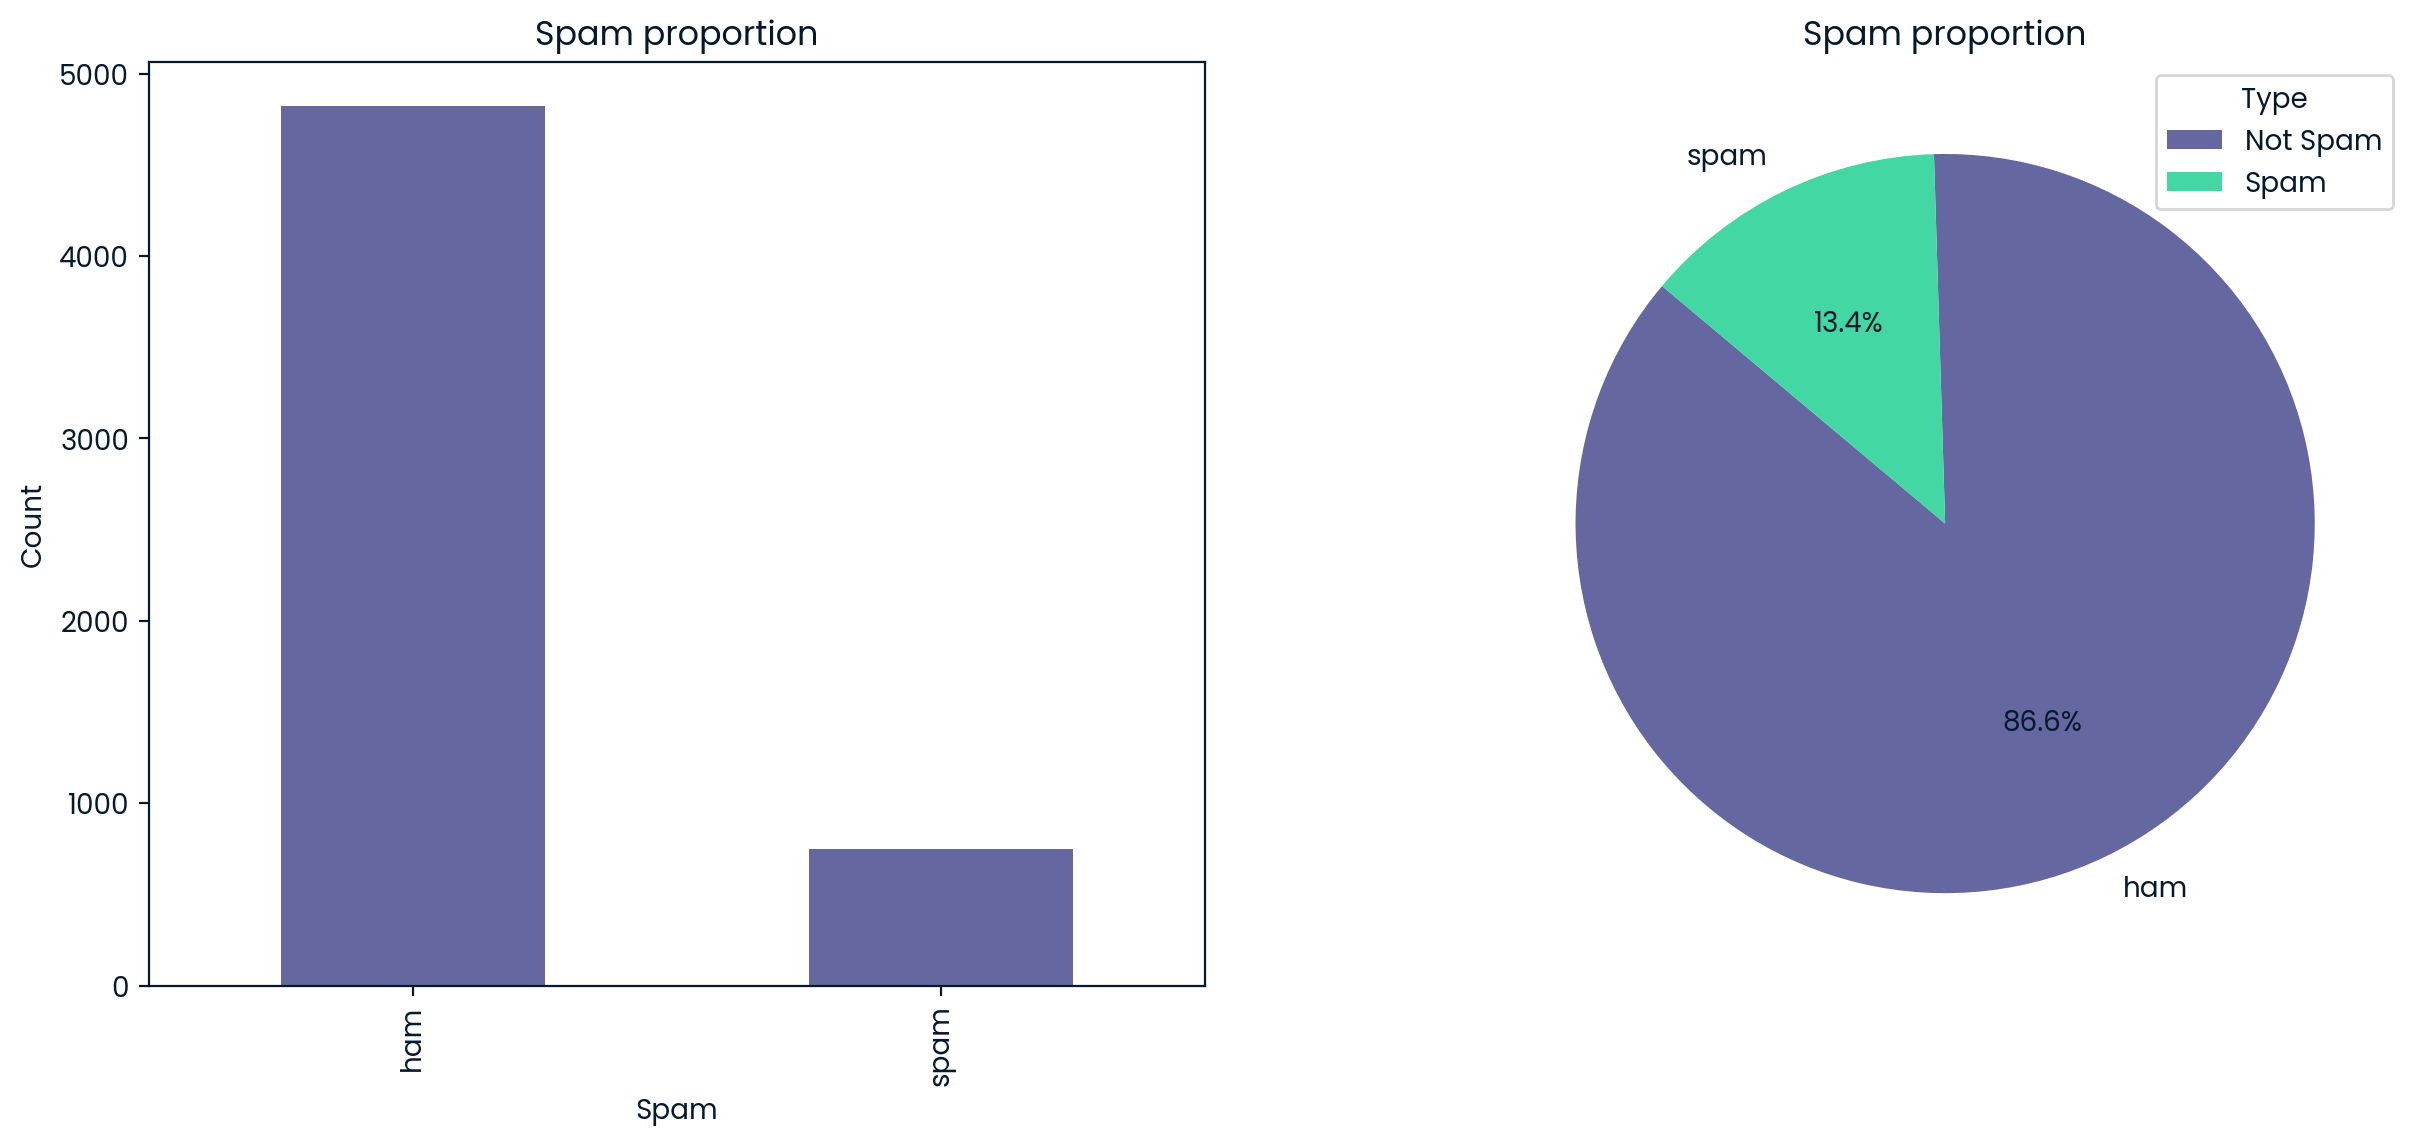

<Figure size 1500x1000 with 0 Axes>

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

v1_count.plot(kind='bar', ax=ax1)
ax1.set_title("Spam proportion")
ax1.set_xlabel("Spam")
ax1.set_ylabel("Count")

# Plot the pie chart
ax2 = plt.pie(v1_count, labels=v1_count.index, autopct='%1.1f%%', startangle=140)
plt.title("Spam proportion")
plt.legend(title='Type', labels=['Not Spam', 'Spam']);
plt.figure(figsize=(15,10))

There is an **imbalance** in the number of instances in the two classes. This will later inform the need and approach of sampling _(SMOTE)_ which I will employ later on.

## Exploratory Data Analysis (EDA)
The dataset is small, I can easily get to know it and decide how to tackle some interesting questions. From the introductory code above we know:
* `v2` is a text column 
* `v1` is the target class and is binary  

First of all, let's ensure there are no nulls:

In [33]:
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [34]:
df.describe(exclude='number').T

,count,unique,top,freq
v1,5572,2,ham,4825
v2,5572,5169,"Sorry, I'll call later",30


<Figure size 1500x1000 with 0 Axes>

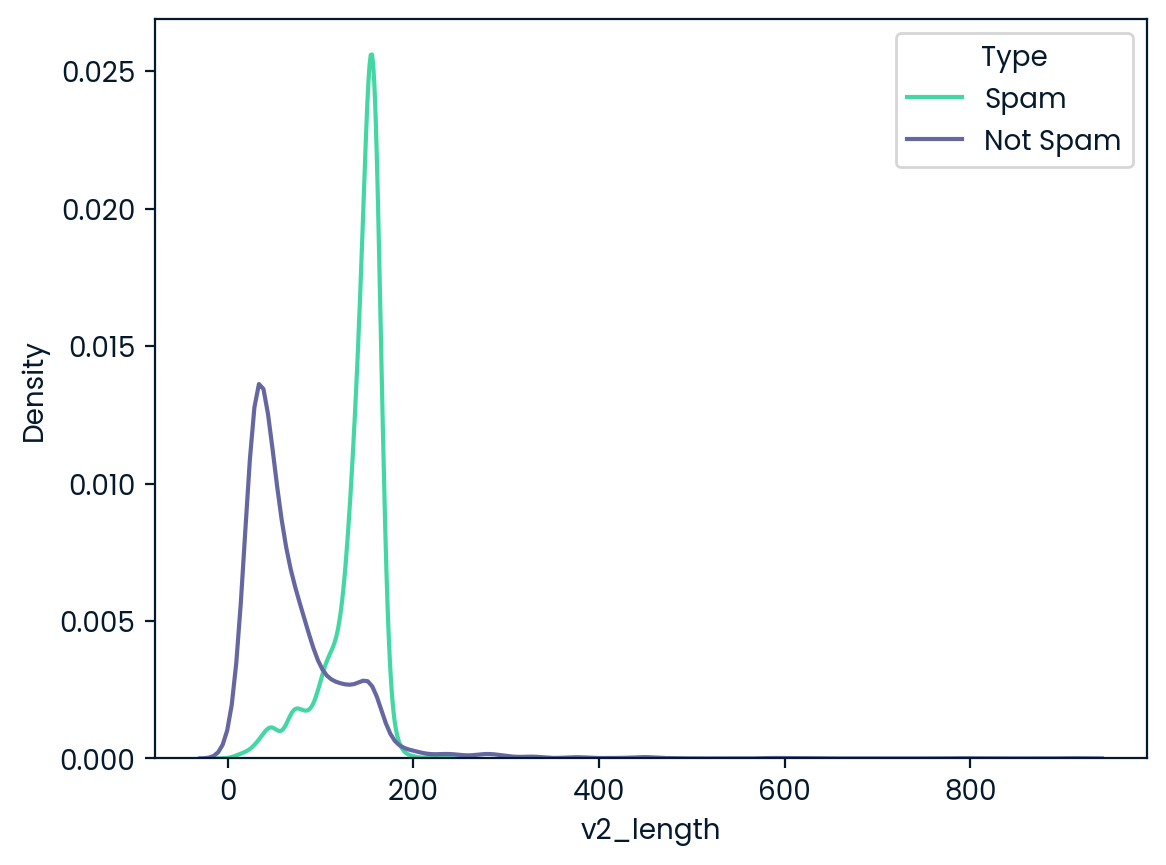

<Figure size 1500x1000 with 0 Axes>

In [35]:
# Let's check the description length distribution:
df['v2_length'] = df['v2'].apply(len)
sns.kdeplot(data=df, x='v2_length', hue='v1', common_norm=False)
plt.legend(title='Type', labels=['Spam', 'Not Spam']);
plt.figure(figsize=(15,10))

The plot shows that I can assume if a message is spam or not from the length of a message. A lengthy message is likely to be spam than a legit message 

## Predict if a message is spam or not

#### Data preproocessing

In [36]:
# Function to preprocess text
nlp = spacy.load('en_core_web_sm')
def preprocess(text):
  	# Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    
    return ' '.join(a_lemmas)

df['v2_preprocessed'] = df['v2'].apply(preprocess)

In [37]:
# Feature engineering to remove redundant features
X = df['v2_preprocessed']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['v1'])


Here, I performed some feature selection necessary to solve the problem. The other features i engineered such as `v2_length` are only necessary for EDA purposes only.

In [38]:

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_train[0:10]

4912    goal arsenal Henry v Liverpool Henry score sim...
2541                                   I send I plus mode
5323                                        Aah bless arm
5171                                   oh I come tomorrow
2532                                               yup ok
4087                        need stop bed fucking dealing
3418    want new video phone anytime network min Inclu...
2568          hey I leave friday wait I ask superior tell
3256                                         tell I drunk
203                                  goodmorning sleep ga
Name: v2_preprocessed, dtype: object

In [39]:
# tokenizing and vectorizing the messages
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()
X_train_vec[0:5]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.61515386, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [40]:
# Train model with oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)
X_train_resampled.shape


(6754, 5088)

The imbalance in the target variable `v2` can result in poor generalization performance, therefore, I had too smote the dataset i.e increasing the instances of the smaller class

In [41]:
# Scale the data
scaler = MinMaxScaler()

#### Setting up the pipelines
Pipelines will be set up for each model I try: Naive Bayes and Support Vector Machines are good models for binary classification, Logistic Regression is included for benchmarking

In [42]:
#set up pipelines with preprocessing & estimators
pipelines = {
    'nb' : make_pipeline(scaler, MultinomialNB()),
    'lr' : make_pipeline(scaler, LogisticRegression(random_state=42)),
    'svc': make_pipeline(scaler, LinearSVC(random_state=42)),
}

#### Evaluating the simple models
The *roc-curve* shows how well the model performs: The more area under the curve, the better the model. We can plot the curve for each of the four models we trained, and show its *accuracy* (ACC) and *Area-Under-the-Curve* (AUC). The visual shows that ***lf* model performed well**, in terms of AUC both the three models have the same ACC.

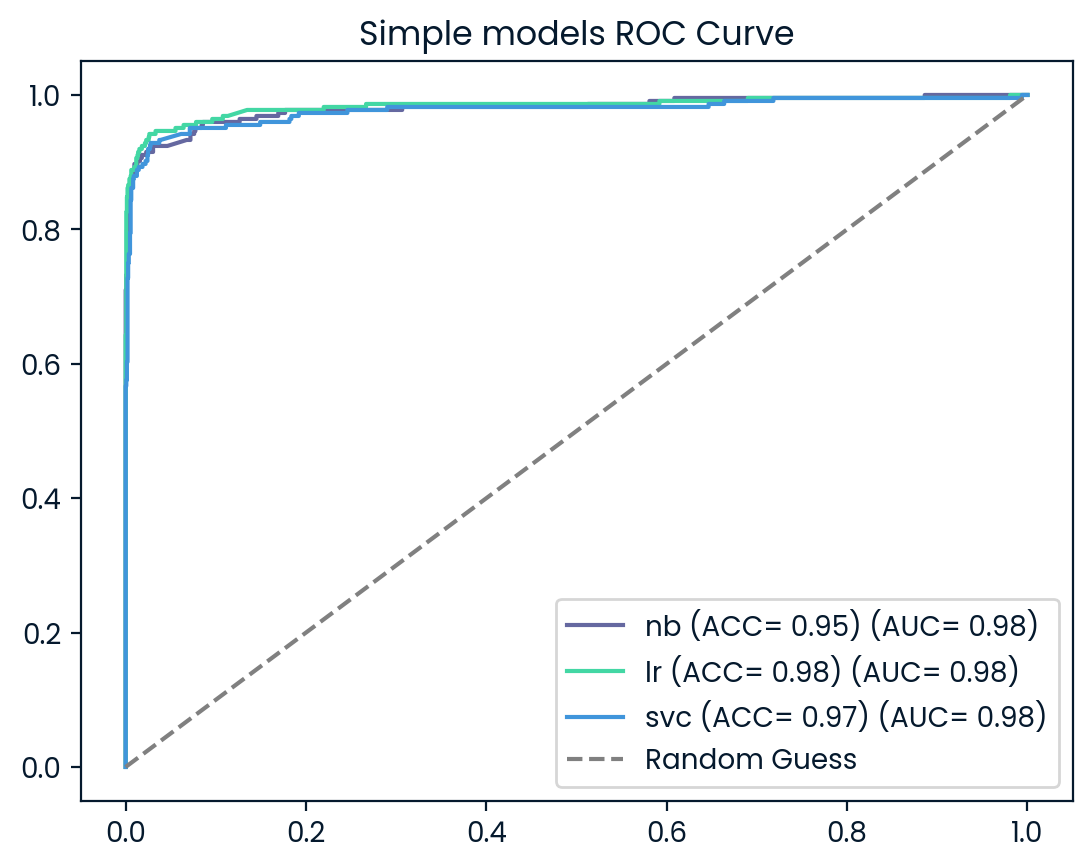

In [43]:

for name, estimator in pipelines.items():
    y_pred = estimator.fit(X_train_resampled, y_train_resampled).predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    
    
    if hasattr(estimator, "predict_proba"):
        y_score = estimator.predict_proba(X_test_vec)[:, 1]
    else:
        y_score = estimator.decision_function(X_test_vec)
        
    auc = roc_auc_score(y_test, y_score)
    fpr, tpr, threshold = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label='{} (ACC= {:.2}) (AUC= {:.2})'.format(name,acc,auc))

plt.plot([0, 1], [0, 1], linestyle="--", c="grey", label='Random Guess')
plt.title("{} ROC Curve".format('Simple models'))
plt.legend()

The visual shows that all ***three* models performed well**, with the same AUC and ACC.

#### Hyperparameter fine-tuning
Now that we have an idea of the bare minimum of model performance we can perform a Grid Search to fine-tune the hyperparameters of each model. The score we want to maximize is *auc*.

In [44]:
#dictionary for hyperparameters (hyperparameter grid) to tune per algorithm:

nb_hyperparameters = {
    'multinomialnb__alpha': [0.001, 0.005, 0.01, 0.05, 0.1],
    'multinomialnb__fit_prior':[True, False],
    'multinomialnb__force_alpha':[True, False]
}

lr_hyperparameters = {
    'logisticregression__C': [0.0001, 0.001, 0.01, 0.1],
    'logisticregression__penalty':['l1','l2'],
    'logisticregression__tol':[0.0001, 0.001, 0.01, 0.1],
    'logisticregression__max_iter':[100, 200,500]
}

svc_hyperparameters = {    
    'linearsvc__C': [0.1, 0.3, 0.6, 0.8, 1],# 1.05, 1.1, 1.15],
    'linearsvc__tol':[0.0001, 0.001, 0.01, 0.1],
    'linearsvc__loss': ['hinge', 'squared_hinge'],
    'linearsvc__penalty': ['l1', 'l2'],
    'linearsvc__class_weight': [None, 'balanced']
}

param_grid = {
    'nb' : nb_hyperparameters,
    'lr' : lr_hyperparameters,
    'svc':svc_hyperparameters,
}


In [45]:
fitted_models = {}
for name, estimator in pipelines.items():
    print("fitting model:",name,"...")
    model = RandomizedSearchCV(estimator, 
                         param_distributions=param_grid[name], 
                         cv=3, 
                         scoring='accuracy',
                         verbose=1, 
                         n_jobs=-1,
                       n_iter=50, 
                       random_state=42
                        )
    model.fit(X_train_resampled, y_train_resampled)
    fitted_models[name] = model
    print('---')
          

fitting model: nb ...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
---
fitting model: lr ...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
---
fitting model: svc ...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
---


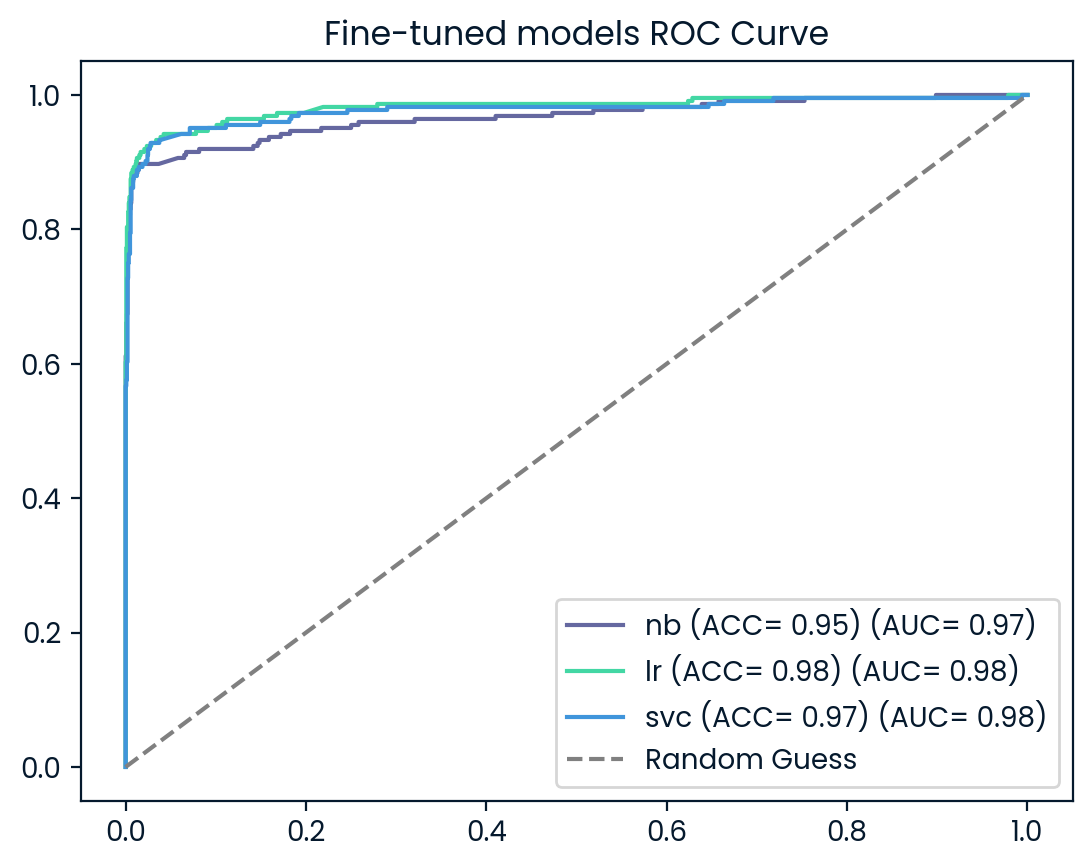

In [46]:
for name, model in fitted_models.items():
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_vec)[:, 1]
    else:
        y_score = model.decision_function(X_test_vec)
        
    auc = roc_auc_score(y_test, y_score)
    fpr, tpr, threshold = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label='{} (ACC= {:.2}) (AUC= {:.2})'.format(name,acc,auc))

plt.plot([0, 1], [0, 1], linestyle="--", c="grey", label='Random Guess')
plt.title("{} ROC Curve".format('Fine-tuned models'))
plt.legend()

#### Focusing on linear SVC
Now, let's try to fine-tune the hyper-parameters of a linear-kernel SVC, maximizing the roc_auc score, and plot the roc curve of the best combination:

In [47]:
def evaluate_model(features, target, model, model_name='Model', title=None, normalize_matrix=None):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    if title is not None:
        f.suptitle(title, fontsize=16)
    
    preds = model.predict(features)
    y_score = model.decision_function(features) 
    
    accuracy = accuracy_score(target, preds)
    precision = precision_score(target, preds)
    recall = recall_score(target, preds)
    f1 = f1_score(target, preds)
    auc = roc_auc_score(target, y_score)

    c_matrix = confusion_matrix(target, preds, normalize=normalize_matrix)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=[False, True])
    
    cm_display.plot(ax=ax1)
    ax1.grid(False)
    ax1.set_title("{} Confusion matrix".format(model_name))

    fpr, tpr, threshold = roc_curve(target, y_score)
    ax2.plot(fpr, tpr, label=model_name)
    ax2.plot([0, 1], [0, 1], linestyle="--", c="grey", label='Random Guess')
    ax2.set_title("{} ROC Curve".format(model_name))
    
    plt.legend()
    plt.figure(figsize=(15,10))
    plt.show()

    print("Accuracy", accuracy.round(2))
    print("Precision:", precision.round(2))
    print("Recall:", recall.round(2))
    print("F1 Score", f1.round(2))
    print("AUC:", auc)
    return None

In [48]:
_hyperparameters = svc_hyperparameters

Fitting 3 folds for each of 160 candidates, totalling 480 fits


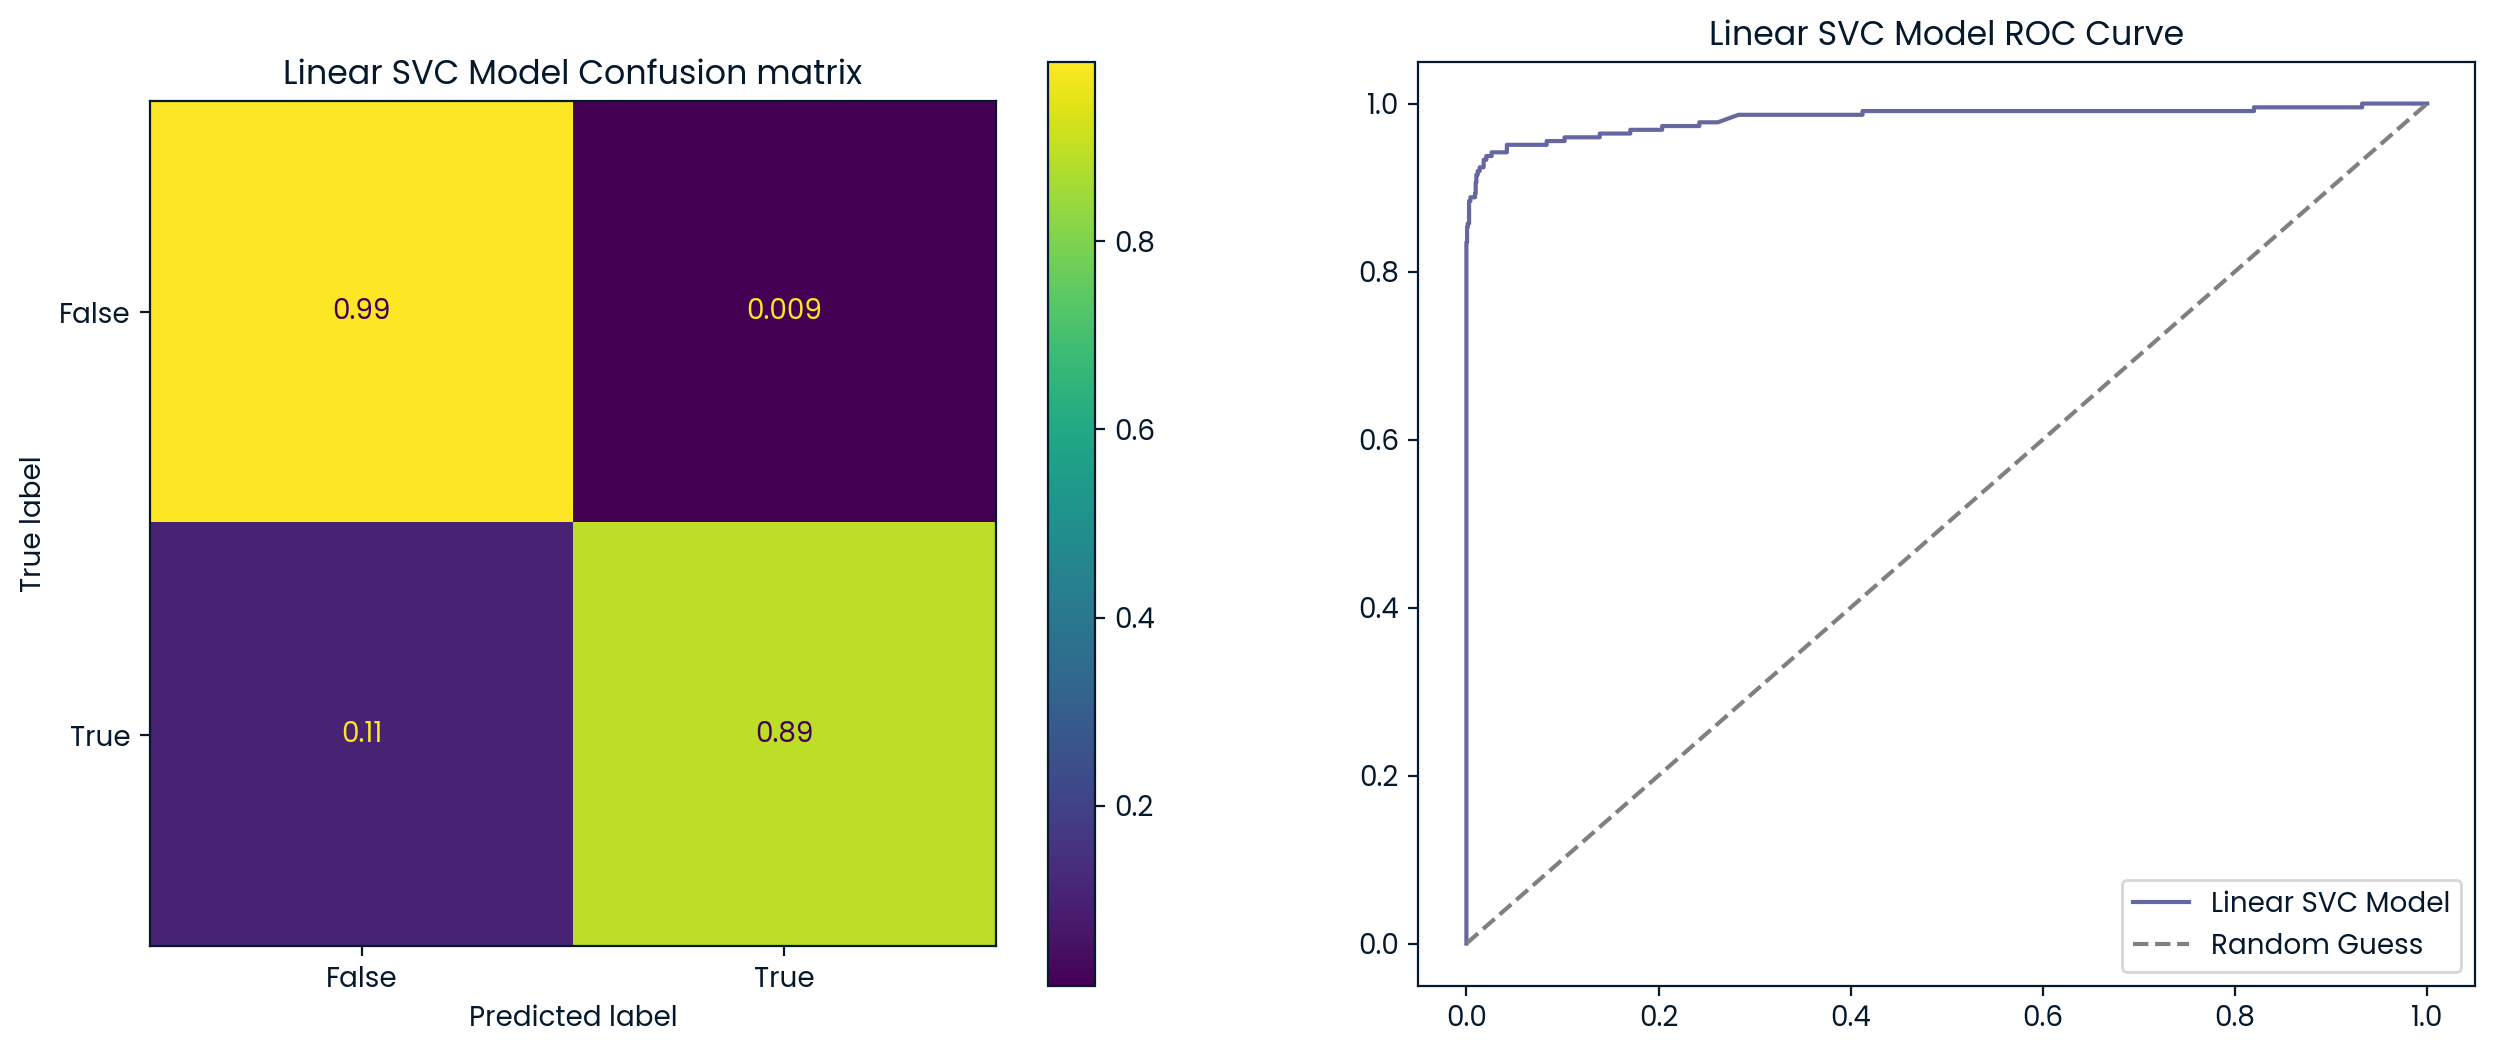

<Figure size 1500x1000 with 0 Axes>

Accuracy 0.98
Precision: 0.94
Recall: 0.89
F1 Score 0.92
AUC: 0.9824696625887924


In [49]:
_pipe = make_pipeline(scaler, LinearSVC(random_state=42))
_grid = GridSearchCV(estimator=_pipe, 
                               param_grid=_hyperparameters, 
                               cv=3, 
                               scoring='accuracy', 
                               verbose =1, 
                               n_jobs=-1)

_grid.fit(X_train_vec, y_train)
evaluate_model(X_test_vec, y_test, _grid, 'Linear SVC Model', normalize_matrix='true')

#### Best Hyperparams

In [50]:
best_params = _grid.best_params_
print(best_params)

{'linearsvc__C': 0.1, 'linearsvc__class_weight': 'balanced', 'linearsvc__loss': 'squared_hinge', 'linearsvc__penalty': 'l2', 'linearsvc__tol': 0.0001}


#### The best model for predicting a spam:


In [51]:
best_model = _grid.best_estimator_
print(best_model)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearsvc',
                 LinearSVC(C=0.1, class_weight='balanced', random_state=42))])


## Conclusion

Linear SVC classifier on training subset with parameters of C=0.3, class_weight=balanced, loss=squared_hinge, penalty=l2, and tol=0.0001. The average precision, recall, and f1-scores on validation subsets were 0.94, 0.89, and 0.92, respectively. The area under ROC (AUC) was 0.98.

Linear SVC model demonstrates an excellent performance across various evaluation metrics. While the accuracy is decent, indicating overall correctness, it also recorded high precision and recall.